# Tarea 5: Construcción de la Red de sensores/subestaciones

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Definir todos los datasets a analizar
datasets = {
    "ener_clean": "Data/ener_clean.csv",
    "ener_noise": "Data/ener_noise.csv",
    "agro_clean": "Data/agro_clean.csv",
    "agro_noise": "Data/agro_noise.csv",
}

graphs = {}  # almacenará un grafo por dataset

required_cols = ["Source_Node", "Target_Node"]

for name, ruta_csv in datasets.items():
    print(f"\n=== Cargando dataset: {name} ({ruta_csv}) ===")
    df = pd.read_csv(ruta_csv)

    # Verificar que existan las columnas requeridas
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"En {name} no encontré la columna '{col}'. Columnas disponibles: {list(df.columns)}")

    # Eliminar filas sin Source_Node o Target_Node para evitar nodos NaN
    df = df.dropna(subset=required_cols)

    # Asegurar tipo entero (por claridad en los nodos)
    df["Source_Node"] = df["Source_Node"].astype(int)
    df["Target_Node"] = df["Target_Node"].astype(int)

    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["Source_Node"], row["Target_Node"])

    graphs[name] = G
    print("Número de nodos:", G.number_of_nodes())
    print("Número de aristas:", G.number_of_edges())


=== Cargando dataset: ener_clean (Data/ener_clean.csv) ===
Número de nodos: 70
Número de aristas: 865

=== Cargando dataset: ener_noise (Data/ener_noise.csv) ===
Número de nodos: 70
Número de aristas: 587

=== Cargando dataset: agro_clean (Data/agro_clean.csv) ===
Número de nodos: 29
Número de aristas: 210

=== Cargando dataset: agro_noise (Data/agro_noise.csv) ===
Número de nodos: 29
Número de aristas: 210


#### CENTRALIDAD DE GRADO Y BETWEENNESS CENTRALITY

In [10]:
degree_centrality = {}
betweenness_centrality = {}
centrality_tables = {}

for name, G in graphs.items():
    print(f"\n=== Centralidades para: {name} ===")
    deg_c = nx.degree_centrality(G)
    bet_c = nx.betweenness_centrality(G)

    degree_centrality[name] = deg_c
    betweenness_centrality[name] = bet_c

    centrality_df = pd.DataFrame({
        "Node": list(G.nodes()),
        "Degree_Centrality": [deg_c[n] for n in G.nodes()],
        "Betweenness_Centrality": [bet_c[n] for n in G.nodes()]
    })
    centrality_df = centrality_df.sort_values(by="Betweenness_Centrality", ascending=False)
    centrality_tables[name] = centrality_df

    print("Top 10 nodos por Betweenness Centrality:")
    print(centrality_df.head(10))


=== Centralidades para: ener_clean ===
Top 10 nodos por Betweenness Centrality:
    Node  Degree_Centrality  Betweenness_Centrality
0  106.0           0.623188                     0.0
1  244.0           0.260870                     0.0
2  113.0           0.623188                     0.0
3  241.0           0.231884                     0.0
4  105.0           0.666667                     0.0
5  233.0           0.260870                     0.0
6  237.0           0.246377                     0.0
7  108.0           0.594203                     0.0
8  206.0           0.246377                     0.0
9  119.0           0.710145                     0.0

=== Centralidades para: ener_noise ===
Top 10 nodos por Betweenness Centrality:
    Node  Degree_Centrality  Betweenness_Centrality
0  106.0           0.376812                     0.0
1  244.0           0.188406                     0.0
2  113.0           0.318841                     0.0
3  241.0           0.144928                     0.0
4  105

#### IDENTIFICAR NODO CUELLO DE BOTELLA


=== Nodo cuello de botella en ener_clean ===
Nodo Cuello de Botella: 106.0
Betweenness Centrality: 0.0

=== Nodo cuello de botella en ener_noise ===
Nodo Cuello de Botella: 106.0
Betweenness Centrality: 0.0

=== Nodo cuello de botella en agro_clean ===
Nodo Cuello de Botella: 4.0
Betweenness Centrality: 0.0

=== Nodo cuello de botella en agro_noise ===
Nodo Cuello de Botella: 4.0
Betweenness Centrality: 0.0

Resumen de cuellos de botella por dataset:
      Dataset  Bottleneck_Node  Betweenness_Centrality
0  ener_clean            106.0                     0.0
1  ener_noise            106.0                     0.0
2  agro_clean              4.0                     0.0
3  agro_noise              4.0                     0.0


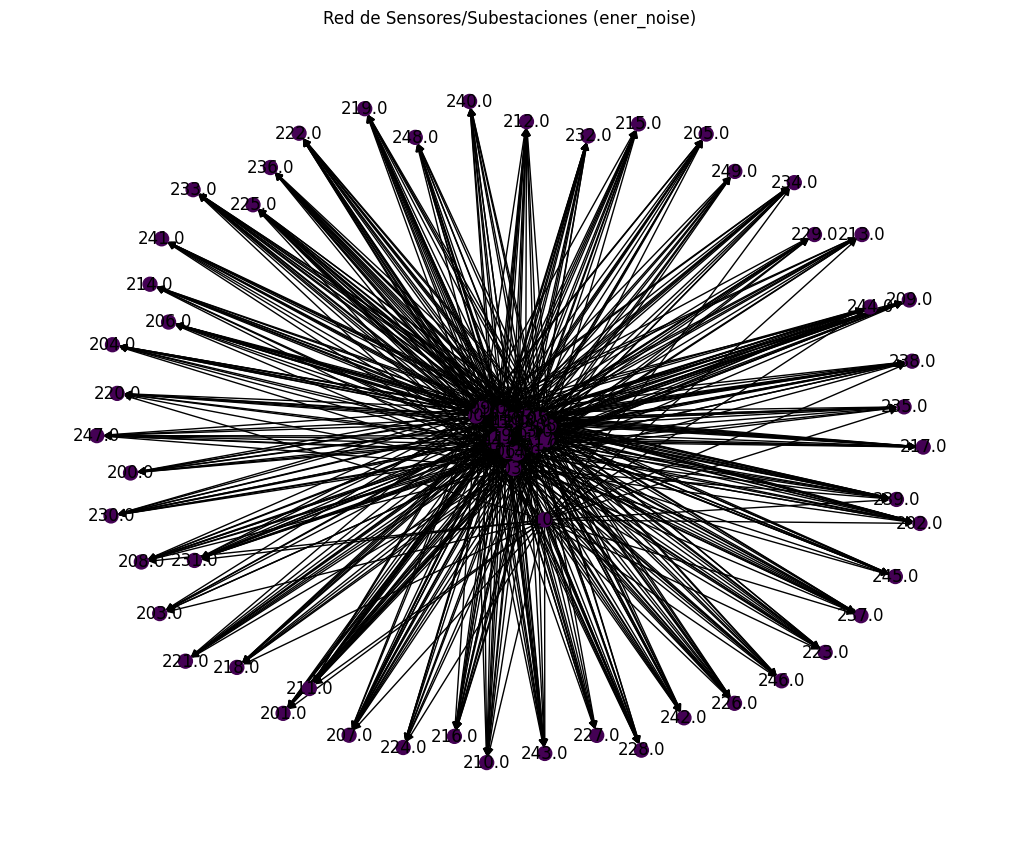

In [11]:
# Identificar nodo cuello de botella (máxima betweenness) para cada dataset
bottleneck_summary = []

for name, centrality_df in centrality_tables.items():
    top = centrality_df.iloc[0]
    bottleneck_node = top["Node"]
    bottleneck_value = top["Betweenness_Centrality"]

    bottleneck_summary.append({
        "Dataset": name,
        "Bottleneck_Node": bottleneck_node,
        "Betweenness_Centrality": bottleneck_value
    })

    print(f"\n=== Nodo cuello de botella en {name} ===")
    print("Nodo Cuello de Botella:", bottleneck_node)
    print("Betweenness Centrality:", bottleneck_value)

bottleneck_df = pd.DataFrame(bottleneck_summary)
print("\nResumen de cuellos de botella por dataset:")
print(bottleneck_df)

# VISUALIZACIÓN: ejemplo para un dataset (ener_noise)
dataset_to_plot = "ener_noise"
G_plot = graphs[dataset_to_plot]
bet_c_plot = betweenness_centrality[dataset_to_plot]

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G_plot, seed=42)

node_sizes = [5000 * bet_c_plot[n] + 100 for n in G_plot.nodes()]
node_colors = [bet_c_plot[n] for n in G_plot.nodes()]

nx.draw(G_plot, pos,
        with_labels=True,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        arrows=True)

plt.title(f"Red de Sensores/Subestaciones ({dataset_to_plot})")
plt.show()